### Focal Narrative Alignment Measure
In this script, we read in interaction data from network interaction experiments and map the hashtag interactions to the focal narrative the group's read. 

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from scipy.special import softmax

/Users/hunter/miniconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
import numpy as np
import pandas as pd
from scipy.special import softmax
from sentence_transformers import util

def softmax_with_temperature(x, tau=1.0):
    scaled_x = x / tau
    return softmax(scaled_x)

def compute_narrative_alignment(df, response_column, model, narrative_segments, tau=1.0):
    # Get responses
    responses = df[response_column].fillna("").astype(str).tolist()

    # Compute embeddings
    segment_embeddings = model.encode(narrative_segments, convert_to_tensor=True)
    response_embeddings = model.encode(responses, convert_to_tensor=True)

    # Compute cosine similarity
    similarity_scores = util.cos_sim(response_embeddings, segment_embeddings)

    # Prepare new columns
    narr_loading = []
    narr_loading_normed = []
    most_similar_segment = []
    segment_index = []
    similarity_score = []

    for i in range(len(responses)):
        row_sim = similarity_scores[i].cpu().numpy()
        softmax_scores = softmax_with_temperature(row_sim, tau=tau)
        best_idx = similarity_scores[i].argmax().item()
        best_score = similarity_scores[i][best_idx].item()

        narr_loading.append(row_sim)
        narr_loading_normed.append(softmax_scores)
        most_similar_segment.append(narrative_segments[best_idx])
        segment_index.append(best_idx)
        similarity_score.append(best_score)

    # Add new columns to original DataFrame
    df["Narr. Loading"] = narr_loading
    df["Narr. Loading (Normed)"] = narr_loading_normed
    df["Most Similar Segment"] = most_similar_segment
    df["Segment Index"] = segment_index
    df["Similarity Score"] = similarity_score

    return df

In [21]:
# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Narrative split into segments (manually or by sentence splitting). Here, I chunk by causal event to allow for causal alignment of narrative interactions. 
narrative_segments = [
    "The Fukushima Nuclear Disaster was a 2011 nuclear accident at the Daiichi Nuclear Power Plant in Fukushima, Japan.",
    "The cause was the Tōhoku earthquake on March 11, 2011, the most powerful earthquake ever recorded in Japan.", #removed 'of the nuclear disaster'
    "It triggered a tsunami with waves up to 130 feet tall, with 45-foot tall waves causing direct damage.", #removed nuclear power plant
    "The damage caused Japanese authorities quickly implemented a 100-foot exclusion zone.", #removed  around the power plant, and radioactive isotopes in reactor coolant to discharge into the sea, therefore 
    "Large quantities of radioactive particles were found shortly after throughout the Pacific Ocean and reached the California coast.",
    "Resulting energy shortage inspired media campaigns to encouraged households and businesses to cut back on electrical usage",
    "Which led to the national movement Setsuden (saving electricity).",
    "The exclusion zone resulted in the displacement of approximately 156,000 people in years to follow.",
    "Independent commissions continue to recognize that affected residents are still struggling and facing grave concerns. A World Health Organization (WHO) report predicts that infant girls exposed to the radiation are 70% more likely to develop thyroid cancer.",
]

/Users/hunter/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
interactions = pd.read_csv('all_interaction_data.csv')
tweets = pd.read_csv('all_tweets.csv')

In [23]:
interactions.to_csv('intearction_vectors.csv', index = False)

In [24]:
print(interactions['random ID'].nunique())
print(tweets['random ID'].nunique())

989
922


In [25]:
interactions_aligned = compute_narrative_alignment(interactions, response_column="Response", model=model, narrative_segments=narrative_segments, tau=0.2)

In [26]:
interactions_aligned.head()

,id,random ID,ResponseType,TrialNumber,Response,Group,Points,prev_response,partner_id,partner_prev_response,...,Identifier,Content,Size,Structure,Run,Narr. Loading,Narr. Loading (Normed),Most Similar Segment,Segment Index,Similarity Score
0,0,89545.0,hashtag,1,stopnuclearpower,5.0,0.0,NaN,18.0,NaN,...,h20s1,Hashtag,20,Spatial,1,"[0.048553765, 0.11593228, 0.1656465, 0.1202638...","[0.07146849, 0.10009795, 0.12834477, 0.1022895...",Which led to the national movement Setsuden (s...,6,0.285683
1,0,89545.0,hashtag,2,endnuclear,8.0,0.0,stopnuclearpower,18.0,saveenergy,...,h20s1,Hashtag,20,Spatial,1,"[0.074948, 0.033099093, 0.08997069, 0.01612552...","[0.13288508, 0.10779596, 0.14325099, 0.099025,...",It triggered a tsunami with waves up to 130 fe...,2,0.089971
2,0,89545.0,hashtag,3,saveenergy,9.0,1.0,endnuclear,18.0,saveenergy,...,h20s1,Hashtag,20,Spatial,1,"[0.12167155, 0.033678725, 0.06264931, 0.018341...","[0.11704315, 0.075382754, 0.08713263, 0.069818...",Which led to the national movement Setsuden (s...,6,0.311161
3,0,89545.0,hashtag,4,saveenergy,9.0,0.0,saveenergy,2.0,saveenergy,...,h20s1,Hashtag,20,Spatial,1,"[0.12167155, 0.033678725, 0.06264931, 0.018341...","[0.11704315, 0.075382754, 0.08713263, 0.069818...",Which led to the national movement Setsuden (s...,6,0.311161
4,0,89545.0,hashtag,5,radiation,1.0,0.0,saveenergy,1.0,radiation,...,h20s1,Hashtag,20,Spatial,1,"[0.29626969, 0.11008199, 0.2178884, 0.07986241...","[0.1533323, 0.060441084, 0.10361697, 0.0519650...",Independent commissions continue to recognize ...,8,0.412476


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind

# Step 1: Mapping indices from narrative vector to narrative entities/events
group_map = {
    0: "Topic", 1: "Causes", 2: "Causes", 3: "Effect",
    4: "1st Order Effects", 5: "1st Order Effects",
    6: "2nd Order Effects", 7: "2nd Order Effects", 8: "2nd Order Effects"
}
# --- we will apply a grouping here to look at the broad narrative components. 
group_labels = ["Topic", "Causes", "Effect", "1st Order Effects", "2nd Order Effects"]

# Step 2: Expand to long format, excluding face names as they do not relate to the narrative
long_rows = []
for _, row in interactions_aligned.iterrows():
    if row["Content"].lower() == "face": #skip face trials
        continue
        
    player = row["random ID"]
    structure = row["Structure"]
    content = row["Content"]
    loading = row["Narr. Loading (Normed)"]
    
    for idx, score in enumerate(loading):
        group_label = group_map.get(idx)
        long_rows.append({
            "Player": player,
            "Structure": structure,
            "Content": content,
            "Group": group_label,
            "Softmax Score": score
        })

long_df = pd.DataFrame(long_rows)

# compute mean 'narrative vector' - aggregate by Player × Structure × Group
agg_df = long_df.groupby(["Player", "Structure", "Group"])["Softmax Score"].mean().reset_index()

# compute condition means across players in a group
summary_df = agg_df.groupby(["Structure", "Group"])["Softmax Score"].agg(['mean', sem]).reset_index()

Topic t = 2.677, p = 0.0077, df = 536.9
Causes t = 3.319, p = 0.0010, df = 560.3
Effect t = 0.988, p = 0.3237, df = 568.2
1st Order Effects t = -4.416, p = 0.0000, df = 564.8
2nd Order Effects t = -5.338, p = 0.0000, df = 498.0


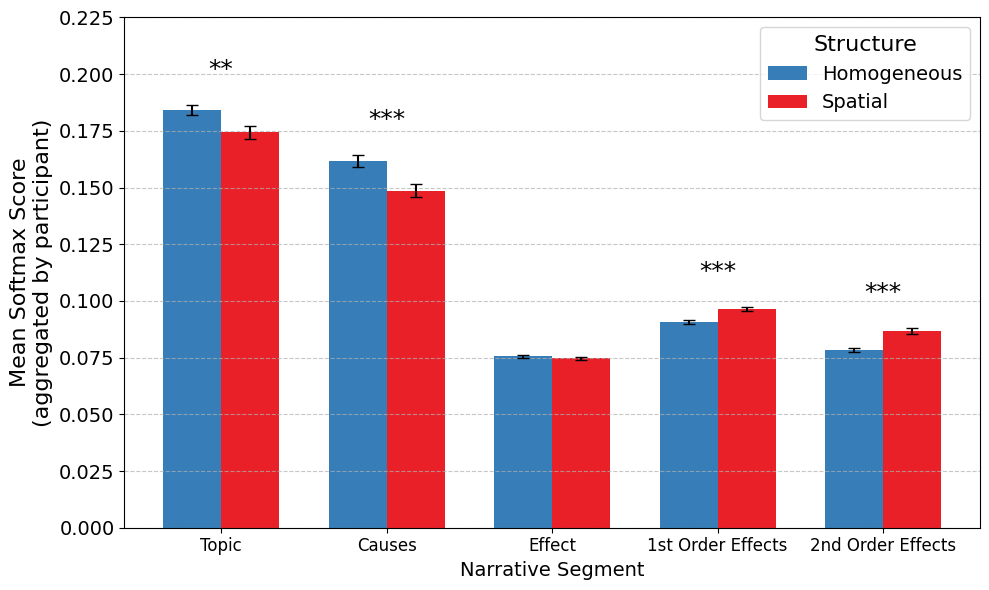

In [28]:
# figure 
structures = ['Homogeneous', 'Spatial']
bar_width = 0.35
x = np.arange(len(group_labels))

structure_colors = {
    'Homogeneous': '#377eb9',
    'Spatial': '#e92028'
}
offsets = {
    'Homogeneous': -0.5 * bar_width,
    'Spatial': 0.5 * bar_width
}

# stats per condition, automatically add the sig stars to the plot based on sig differences
significance_annotations = {}  
for label in group_labels:
    group_data = agg_df[agg_df["Group"] == label]
    scores_homog = group_data[group_data["Structure"] == "Homogeneous"]["Softmax Score"]
    scores_spatial = group_data[group_data["Structure"] == "Spatial"]["Softmax Score"]
    if len(scores_homog) > 1 and len(scores_spatial) > 1:
        result = ttest_ind(scores_homog, scores_spatial, equal_var=False)

        t_stat = result.statistic
        p_val = result.pvalue
        df = result.df

        print(label, f"t = {t_stat:.3f}, p = {p_val:.4f}, df = {df:.1f}")

        if p_val < 0.001:
            stars = '***'
        elif p_val < 0.01:
            stars = '**'
        elif p_val < 0.05:
            stars = '*'
        else:
            stars = ''
        
        significance_annotations[label] = stars

fig, ax = plt.subplots(figsize=(10, 6))

for structure in structures:
    subset = summary_df[summary_df["Structure"] == structure]
    means = []
    errors = []
    for label in group_labels:
        row = subset[subset["Group"] == label]
        means.append(row["mean"].values[0] if not row.empty else 0)
        errors.append(row["sem"].values[0] if not row.empty else 0)

    offset = offsets[structure]
    ax.bar(
        x + offset,
        means,
        yerr=errors,
        width=bar_width,
        capsize=4,
        label=structure,
        color=structure_colors[structure]
    )

# add significance stars
for i, label in enumerate(group_labels):
    stars = significance_annotations.get(label, "")
    if stars:
        y_vals = []
        for structure in structures:
            subset = summary_df[(summary_df["Structure"] == structure) & (summary_df["Group"] == label)]
            if not subset.empty:
                y_vals.append(subset["mean"].values[0] + subset["sem"].values[0])
        if y_vals:
            ax.text(
                x[i],
                max(y_vals) + 0.01,
                stars,
                ha='center',
                va='bottom',
                fontsize=18,
                color='black'
            )

# Final formatting
ax.set_xticks(x)
ax.set_xticklabels(group_labels, fontsize=12)
ax.set_xlabel("Narrative Segment", fontsize=14)
ax.set_ylabel("Mean Softmax Score\n(aggregated by participant)", fontsize=16)
ax.legend(title="Structure", fontsize=14, title_fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim([0, 0.225])

plt.tight_layout()
plt.show()


In [29]:
# Additional comments

### Additional comments. 

You could theoretically break the narrative text into differnt sub components based on specific string boundaries. For example, here is distiguishing the energy shortages event. The statisical tests remain the same, but it running the focal narrative alignment measure and tests with this grouping shows how t-values can shift based on different narrative event text boundaries. All comparisons and inferences remain the same however. 

In [30]:
narrative_segments = [
    "The Fukushima Nuclear Disaster was a 2011 nuclear accident at the Daiichi Nuclear Power Plant in Fukushima, Japan.",
    "The cause was the Tōhoku earthquake on March 11, 2011, the most powerful earthquake ever recorded in Japan.", #removed 'of the nuclear disaster'
    "It triggered a tsunami with waves up to 130 feet tall, with 45-foot tall waves causing direct damage.", #removed nuclear power plant
    "The damage caused Japanese authorities quickly implemented a 100-foot exclusion zone.", #removed  around the power plant, and radioactive isotopes in reactor coolant to discharge into the sea, therefore 
    "Large quantities of radioactive particles were found shortly after throughout the Pacific Ocean and reached the California coast.",
    "Resulting energy shortage",
    "inspired media campaigns to encouraged households and businesses to cut back on electrical usage, which led to the national movement Setsuden (saving electricity).",
    "The exclusion zone resulted in the displacement of approximately 156,000 people in years to follow.",
    "Independent commissions continue to recognize that affected residents are still struggling and facing grave concerns. A World Health Organization (WHO) report predicts that infant girls exposed to the radiation are 70% more likely to develop thyroid cancer.",
]